In [52]:
import torchvision.transforms as transforms
import torch

transform_to_gray = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ConvertImageDtype(dtype=torch.float32)  # Convertir a flotante si es necesario
])

image = transform_to_gray(tensor)

In [55]:
holi = image.unsqueeze(0)

In [56]:
holi.ndim

4

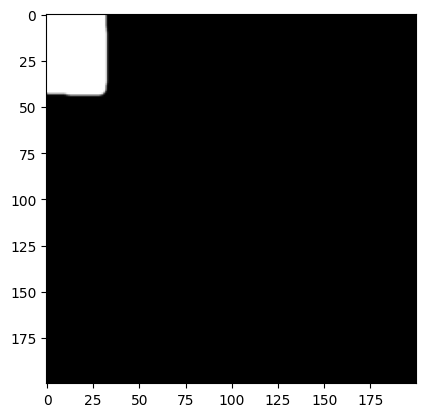

In [59]:
otra = holi.squeeze()

plt.imshow(otra, cmap='gray')
plt.savefig("test.png")

In [50]:
import torch 
from torchvision.transforms import Resize

tensor = torch.from_numpy(lista[0]['composite'][:,:,3]).unsqueeze(0)
# tensor = torch.
# plt.imshow(tensor, cmap='gray')

In [51]:
tensor

tensor([[[255, 255, 255,  ...,   0,   0,   0],
         [255, 255, 255,  ...,   0,   0,   0],
         [255, 255, 255,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8)

In [40]:
tensor.unsqueeze(0)

tensor([[[255, 255, 255,  ...,   0,   0,   0],
         [255, 255, 255,  ...,   0,   0,   0],
         [255, 255, 255,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8)

In [43]:
tensor.ndim

3

In [44]:
modificar_size = Resize((200,200))
tensor_modificado = modificar_size(tensor)

In [45]:
tensor_modificado

tensor([[[255, 255, 255,  ...,   0,   0,   0],
         [255, 255, 255,  ...,   0,   0,   0],
         [255, 255, 255,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8)

In [26]:
tensor.dtype

torch.uint8

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

class CNN(nn.Module):
  def __init__(self, in_channels=1, num_classes=4):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    # self.fc1 = nn.Linear(16*7*7, num_classes)
    self.fc1 = nn.Linear(200*200, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    return x

In [8]:
model = CNN()
model.load_state_dict(torch.load('gabriel_modelo.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
def inference(model, imagen, device="cpu"):
    label_mapping = {0: "círculo", 1: "triángulo", 2: "cuadrado", 3: "estrella"}

    model.eval()  # Ponemos el modelo en modo evaluación

    # Realizar la inferencia
    with torch.no_grad():
        scores = model(imagen)
        _, prediction = scores.max(1)
        label_predicho = prediction.item()

    # Obtener nombres de etiquetas
    # label_real_name = label_mapping.get(label_real, "Desconocido")
    label_predicho_name = label_mapping.get(label_predicho, "Desconocido")

    # model.train()  # Restauramos el modelo a modo entrenamiento
    
    return label_predicho_name

In [ ]:
import numpy as np

def predict(img):  
    # 1º: Recibimos un diccionario con 3 keys(), dentro contienen distintos arrays, accedemos al array de nuestro interés
    # Cabe indicar que el tamaño del array es de (800,800)
    image_array = img['composite'][:,:,3]
    image_array = 255 - image_array

    # listita.append(image_array)
    # 2º: Convertirmos el array a un tensor, el cual tendrá un ndim=2 y dtype=uint8. Debemos agregar dos dimensiones y convertir de uint8 a float32
    #     Utilizando unsqueeze(0) agregamos una dimensión, para que quede de la siguiente forma (1,800,800)
    image_tensor = torch.from_numpy(image_array).unsqueeze(0)

    # 3º: Debemos seguir modificando las dimensiones para que queden de la forma en que se entrenó el modelo 
    # a) El modelo recibe un tensor con ndim=4, dtype=torch.float32 y un shape=(64, 1, 200, 200)
    transform_to_gray = transforms.Compose([
    transforms.Resize((200,200)),
    # transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ConvertImageDtype(dtype=torch.float32)  # Convertir a flotante si es necesario
    ])

    image = transform_to_gray(image_tensor)

    # 4º: Agregamos la útlima dimensión:
    image = image.unsqueeze(0)

    # 5º: Hacemos la inferencia
    label_predict = inference(model, image, device="cpu")
    print(label_predict)

    # 6º: Convertimos la imagen devuelta
    img_devuelta = image.squeeze()
    plt.imshow(img_devuelta, cmap="gray")
    plt.title(f"Predicción: {label_predict}")
    plt.axis("off")
    plt.savefig(f"Predicción {label_predict}.png")

    return label_predict

In [ ]:
import gradio as gr

with gr.Blocks() as demo:
    with gr.Row():
        im = gr.Sketchpad(
            type="numpy",
            crop_size="1:1",
            # image_mode='L',
            # layers=True
        )
        im_preview = gr.Image()

        out = gr.Label()

    im.change(predict, outputs=im_preview, inputs=im, show_progress="hidden")

demo.launch(share=False, debug=False)

c:\Users\gol_m\anaconda3\envs\programacion_2\lib\site-packages\gradio\components\image_editor.py:253: UserWarning: `crop_size` parameter is deprecated. Please use `canvas_size` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


triángulo
triángulo
triángulo
triángulo


In [ ]:
# 1º: Recibimos un diccionario con 3 keys(), dentro contienen distintos arrays, accedemos al array de nuestro interés
# Cabe indicar que el tamaño del array es de (800,800)
image_array = img['composite'][:,:,3]
listita.append(image_array)
# 2º: Convertirmos el array a un tensor, el cual tendrá un ndim=2 y dtype=uint8. Debemos agregar dos dimensiones y convertir de uint8 a float32
#     Utilizando unsqueeze(0) agregamos una dimensión, para que quede de la siguiente forma (1,800,800)
image_tensor = torch.from_numpy(image_array).unsqueeze(0)

# 3º: Debemos seguir modificando las dimensiones para que queden de la forma en que se entrenó el modelo 
# a) El modelo recibe un tensor con ndim=4, dtype=torch.float32 y un shape=(64, 1, 200, 200)
transform_to_gray = transforms.Compose([
transforms.Resize((200,200)),
# transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
transforms.ConvertImageDtype(dtype=torch.float32)  # Convertir a flotante si es necesario
])

image = transform_to_gray(image_tensor)

# 4º: Agregamos la útlima dimensión:
image = image.unsqueeze(0)

# 5º: Hacemos la inferencia
label_predict = inference(model, image, device="cpu")
print(label_predict)

img_devuelta = image.squeeze()
plt.imshow(img_devuelta, cmap="gray")
plt.title(f"Predicción: {label_predict}")
plt.axis("off")
plt.savefig("image.png")